# <div style="text-align: center; color: #1a5276;">Hyperparameter Tunning</div>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3) 
4. [Data](#4) 
5. [Model](#5)
6. [Training Functions](#6)
7. [Hyperparameter Tunning](#7)
8. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

In this notebook, we demonstrate how to perform hyperparameter tuning for a PyTorch model using Ray Tune. We will define a training function compatible with Ray Tune’s API, specify a search space for key hyperparameters (e.g., learning rate, batch size, network size), and leverage Ray Tune’s schedulers to efficiently explore and optimize the configuration. The goal is to identify the best set of hyperparameters that minimize validation loss while maintaining good generalization performance.

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [2]:
#!pip install -U ray

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from ray import tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

import matplotlib.pyplot as plt

<a name="3"></a>
## <font color='blue'> 3. Helper Functions </font>

In [16]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train):
    # Move to numpy for plotting
    X = X_train.numpy()
    y = y_train.squeeze(1).numpy()

    print(f"Training set size: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Validation set size: {len(y)} samples")
    print(f"Target y mean: {y.mean():.4f}, std: {y.std():.4f}")

    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Scatter: y vs first feature
    axes[0].scatter(X[:, 0], y, s=10)
    axes[0].set_xlabel("Feature X[:,0]")
    axes[0].set_ylabel("Target y")
    axes[0].set_title("y vs X[:,0]")

    # Scatter: y vs second feature
    axes[1].scatter(X[:, 1], y, s=10)
    axes[1].set_xlabel("Feature X[:,1]")
    axes[1].set_ylabel("Target y")
    axes[1].set_title("y vs X[:,1]")

    # Histogram of y
    axes[2].hist(y, bins=30)
    axes[2].set_xlabel("Target y")
    axes[2].set_title("Distribution of y (training)")

    plt.tight_layout()
    plt.show()


<a name="4"></a>
## <font color='blue'> 4. Data </font>

Let's start by creating synthetic data.

In [8]:
def get_data():
    np.random.seed(0)
    X = np.random.rand(1000, 5)
    y = 3 * X[:, 0] + 2 * X[:, 1] + np.random.randn(1000) * 0.1

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1),
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(1),
    )

In [11]:
X_train, y_train, X_val, y_val = get_data()
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([800, 5]),
 torch.Size([800, 1]),
 torch.Size([200, 5]),
 torch.Size([200, 1]))

In this problem, we have 5 features and 1 output label. It is a regression problem.

Training set size: 800 samples, 5 features
Validation set size: 800 samples
Target y mean: 2.4629, std: 1.0346


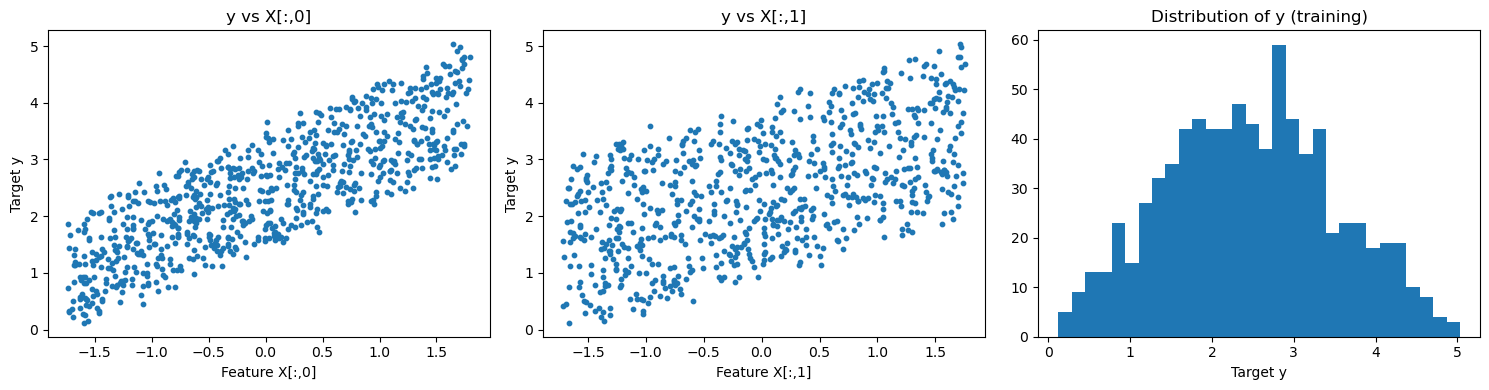

In [17]:
plot_data(X_train, y_train)

<a name="5"></a>
## <font color='blue'> 5. Model </font>

We will create a simple model for testing purposes.

In [15]:
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        return self.net(x)

<a name="6"></a>
## <font color='blue'> 6. Training Functions </font>

In [19]:
# custom metric: R2 score
def r2_score(preds, targets):
    ss_res = torch.sum((targets - preds) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    return 1 - ss_res / ss_tot

In [23]:
# Train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    count = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        count += xb.size(0)
    return total_loss / count

# Validate
def validate(model, X_val, y_val, criterion):
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val).item()
        val_r2 = r2_score(val_pred, y_val).item()
    return val_loss, val_r2


Note: Since this project uses Ray Tune for hyperparameter tuning, the train_model function is adapted to work with Ray Tune’s API. In particular, it takes a config dictionary as a parameter, which contains the hyperparameters for the current trial (e.g., learning rate, hidden layer size, batch size, number of epochs).

In [35]:
# Train function
import tempfile
from ray import tune
from ray.tune import Checkpoint

def train_model(config):
    """
    Train a SimpleRegressor model and report metrics/checkpoints to Ray Tune.

    Expected keys in `config`:
        - "hidden_dim": int, hidden layer size for the regressor.
        - "lr": float, learning rate for the optimizer.
        - "batch_size": int or convertible, batch size for training loader.
        - "max_num_epochs": int, number of epochs to run.

    Reports the following to Ray Tune each epoch:
        - train_loss: training loss for that epoch.
        - loss: validation loss.
        - val_r2: validation R² score.
        - epoch: current epoch index.
        - checkpoint: model state saved as a Ray Tune Checkpoint.
    """
    # Fetch data (assumed to return tensors: X_train, y_train, X_val, y_val)
    X_train, y_train, X_val, y_val = get_data()

    # Instantiate model with hyperparameter from config
    model = SimpleRegressor(input_dim=5, hidden_dim=config["hidden_dim"])

    # Use mean squared error for regression
    criterion = nn.MSELoss()
    # Adam optimizer with learning rate from config
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # Prepare training DataLoader
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=int(config["batch_size"]),
        shuffle=True,
    )

    # Epoch loop
    for epoch in range(config["max_num_epochs"]):
        # Train for one epoch and get training loss
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)

        # Evaluate on validation set
        val_loss, val_r2 = validate(model, X_val, y_val, criterion)

        # Save a checkpoint of the current model state in a temporary directory
        with tempfile.TemporaryDirectory() as tmpdir:
            path = f"{tmpdir}/model.pth"
            torch.save(model.state_dict(), path)  # persist model weights
            ckpt = Checkpoint.from_directory(tmpdir)  # wrap for Ray Tune

            # Report metrics and checkpoint to Ray Tune
            tune.report(
                {
                    "train_loss": train_loss,
                    "loss": val_loss,       # Ray Tune expects "loss" as the primary objective name by default
                    "val_r2": val_r2,
                    "epoch": epoch,
                },
                checkpoint=ckpt,
            )


In [36]:
# To test the best model
def test_best_model(best_result, smoke_test=False):
    X_train, y_train, X_val, y_val = get_data()
    model = SimpleRegressor(input_dim=5, hidden_dim=best_result.config["hidden_dim"])

    # Load checkpoint weights
    checkpoint_path = best_result.checkpoint.to_directory()
    state_dict = torch.load(f"{checkpoint_path}/model.pth",  weights_only=True)
    model.load_state_dict(state_dict)

    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        mse = nn.MSELoss()(preds, y_val).item()
        r2 = 1 - mse / torch.var(y_val).item()
        print(f"[TEST] Final MSE: {mse:.4f}, R²: {r2:.4f}")

<a name="7"></a>
## <font color='blue'> 7. Hyperparameter Tunning </font>


In [37]:
def main(config, gpus_per_trial=1):
    """
    Run a Ray Tune hyperparameter search using ASHA for early stopping,
    then evaluate the best-found model.

    Args:
        config (dict): Configuration / search space for tuning. Expected to contain:
            - "max_num_epochs": int, max epochs per trial (used by ASHAScheduler).
            - "num_trials": int, number of sampled trials.
            - Any other hyperparameters consumed by `train_model` (e.g., "lr", "hidden_dim", etc.).
            - Optional "smoke_test": bool, if True, `test_best_model` will run a quick sanity check.
        gpus_per_trial (int): Number of GPUs to allocate to each trial.

    Returns:
        ray.tune.result_grid.ResultGrid: The full tuning results object.
    """
    # Set up ASHA scheduler for aggressive early stopping of underperforming trials
    scheduler = ASHAScheduler(
        time_attr="training_iteration",
        max_t=config["max_num_epochs"],
        grace_period=1,
        reduction_factor=2,
    )

    # Build the tuner, injecting resources and the trainable function
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model),  # train_model must accept `config`
            resources={"cpu": 2, "gpu": gpus_per_trial},
        ),
        tune_config=tune.TuneConfig(
            metric="loss",          # objective to minimize
            mode="min",
            scheduler=scheduler,    # use ASHA for scheduling
            num_samples=config["num_trials"],  # how many hyperparameter samples
        ),
        param_space=config,  # full config/search space passed to each trial
    )

    # Execute the tuning run
    results = tuner.fit()

    # Extract best trial according to validation loss
    best_result = results.get_best_result("loss", "min")

    # Report best trial summary
    print(f"\n✅ Best trial config: {best_result.config}")
    print(f"✅ Best trial final validation loss: {best_result.metrics['loss']:.4f}")
    print(f"✅ Best trial final validation R²: {best_result.metrics['val_r2']:.4f}")

    # Run final test / possibly a quick smoke test on the best model
    test_best_model(best_result, smoke_test=config.get("smoke_test", False))

    return results


Define Ray Tune’s search space. 

In [38]:
search_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "hidden_dim": tune.choice([16, 32, 64]),
    "batch_size": tune.choice([16, 32, 64]),
    "max_num_epochs": 10,
    "num_trials": 5,
    "smoke_test": False,
}

Execute main

In [39]:
r = main(search_config, gpus_per_trial=1 if torch.cuda.is_available() else 0)

(train_model pid=496184) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/marcos/ray_results/train_model_2025-08-01_16-12-55/train_model_8753b_00001_1_batch_size=32,hidden_dim=64,lr=0.0189_2025-08-01_16-12-55/checkpoint_000000)
(train_model pid=496184) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/marcos/ray_results/train_model_2025-08-01_16-12-55/train_model_8753b_00001_1_batch_size=32,hidden_dim=64,lr=0.0189_2025-08-01_16-12-55/checkpoint_000001)
(train_model pid=496184) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/marcos/ray_results/train_model_2025-08-01_16-12-55/train_model_8753b_00001_1_batch_size=32,hidden_dim=64,lr=0.0189_2025-08-01_16-12-55/checkpoint_000002)
(train_model pid=496338) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/marcos/ray_results/train_model_2025-08-01_16-12-55/train_model_8753b_00003_3_batch_size=16,hidden_dim=32,lr=0.0045_2025-08-01_16-12-55


✅ Best trial config: {'lr': 0.0189051728301868, 'hidden_dim': 64, 'batch_size': 32, 'max_num_epochs': 10, 'num_trials': 5, 'smoke_test': False}
✅ Best trial final validation loss: 0.0115
✅ Best trial final validation R²: 0.9899
[TEST] Final MSE: 0.0115, R²: 0.9899


In [40]:
# To see clearly the best hyperparameters
r.get_best_result("loss", "min").config

{'lr': 0.0189051728301868,
 'hidden_dim': 64,
 'batch_size': 32,
 'max_num_epochs': 10,
 'num_trials': 5,
 'smoke_test': False}

<a name="references"></a>
## <font color='blue'> References </font>

[Ray Tune](https://docs.pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)